# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim
from IPython.display import clear_output

In [2]:
!pip install xmltodict

In [3]:
import xmltodict

# Extraction of Images and Annotations

In [4]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [5]:
path_annotations = "/kaggle/input/face-mask-detection/annotations/" 
listing = []
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc = xmltodict.parse(fd.read())
    temp = doc["annotation"]["object"]
    if type(temp) == list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


# Visualisation and Analysis of Target Class

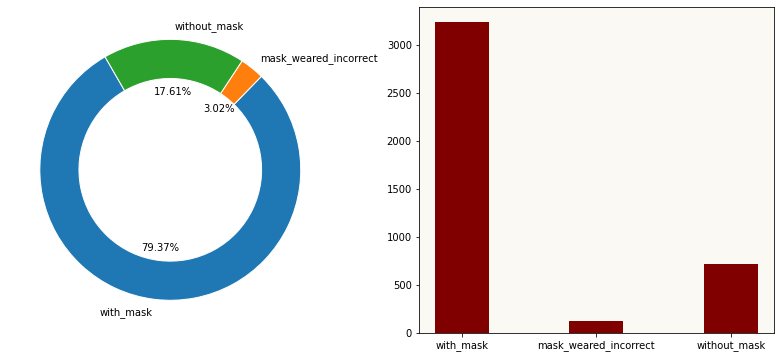

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()


# Images Identification with Target Class

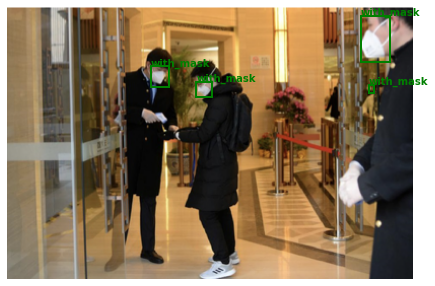

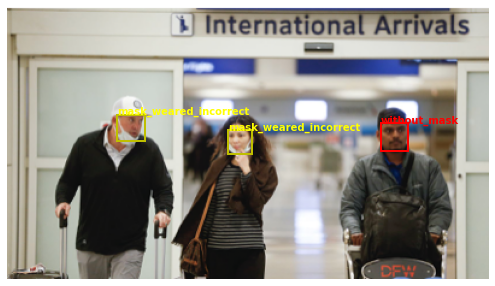

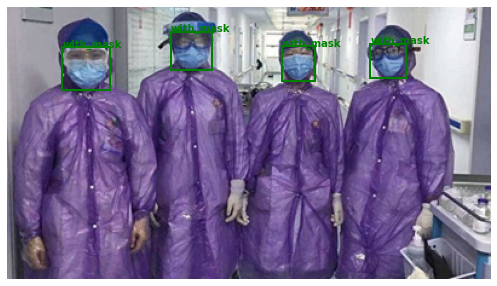

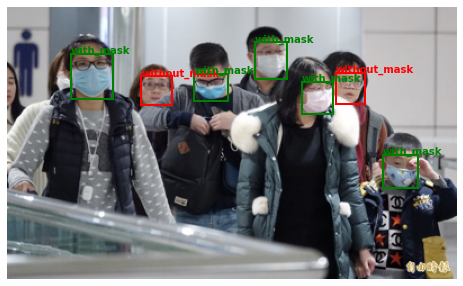

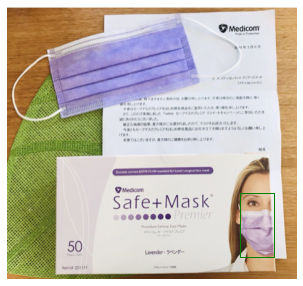

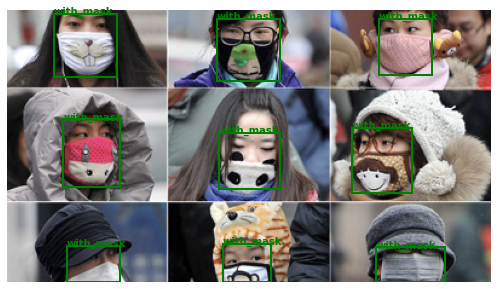

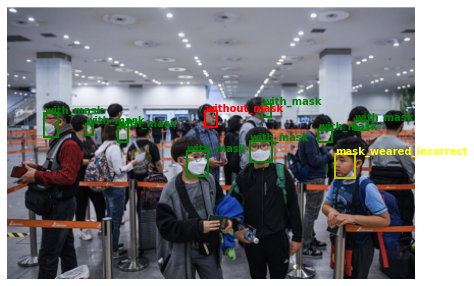

In [8]:
path_image = "/kaggle/input/face-mask-detection/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc = xmltodict.parse(fd.read())
    image = plt.imread(os.path.join(path_image+img))
    fig, ax = plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp = doc["annotation"]["object"]
    if type(temp) == list:
        for i in range(len(temp)):
            #with_mask
            if temp[i]["name"]=="with_mask":
                x, y, w, h = list(map(int,temp[i]["bndbox"].values()))
                mpatch = mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            #without_mask
            if temp[i]["name"] == "without_mask":
                x, y, w, h = list(map(int,temp[i]["bndbox"].values()))     
                mpatch = mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            #mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x, y, w, h = list(map(int,temp[i]["bndbox"].values()))
                mpatch = mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x, y, w, h = list(map(int,temp["bndbox"].values()))
        edgecolor = {"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch = mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,8):
    face_cas(fun_images[i])

# Image Preprocessing

In [9]:
options={"with_mask":1,"without_mask":2,"mask_weared_incorrect":3} 

In [10]:
img_names[:10]

['maksssksksss810.png',
 'maksssksksss848.png',
 'maksssksksss145.png',
 'maksssksksss825.png',
 'maksssksksss30.png',
 'maksssksksss323.png',
 'maksssksksss805.png',
 'maksssksksss613.png',
 'maksssksksss315.png',
 'maksssksksss295.png']

In [11]:
np.random.shuffle(img_names)
train_imgs = img_names[:int(len(img_names)*0.8)]
val_imgs = img_names[int(len(img_names)*0.8):]

In [12]:
data_transforms=transforms.Compose([
        transforms.ToTensor(), 
    ])

In [13]:
path_image = "/kaggle/input/face-mask-detection/images/"  

In [14]:
class MasksDetection(Dataset):
    
    def __init__(self, imgs_name, transforms=transforms):
        self.transforms = transforms
        self.imgs_name = imgs_name
        
        
    def __len__(self):
        return len(self.imgs_name)
    
    def __getitem__(self, idx):
        with open(path_annotations + self.imgs_name[idx][:-4] + ".xml") as fd:
            doc = xmltodict.parse(fd.read())
            temp = doc["annotation"]["object"]
            target = {}
            labels = []
            boxes = []
            if type(temp) == list:
                for i in temp:
                    labels.append(options[i['name']])
                    boxes.append(list(map(int,list(i['bndbox'].values()))))
            else:
                labels.append(options[temp['name']])
                boxes.append(list(map(int,list(temp['bndbox'].values()))))
            labels = torch.LongTensor(labels)
            boxes = torch.FloatTensor(boxes)
            target['boxes'] = boxes
            target['labels'] = labels
            target['img_id'] = torch.LongTensor([int(self.imgs_name[idx][12:-4])])
            return self.transforms(Image.open(path_image + self.imgs_name[idx]).convert("RGB")), target
        
        
    
    

In [15]:
doc["annotation"]["object"]

[{'name': 'with_mask',
  'pose': 'Unspecified',
  'truncated': '0',
  'occluded': '0',
  'difficult': '0',
  'bndbox': {'xmin': '114', 'ymin': '40', 'xmax': '142', 'ymax': '76'}},
 {'name': 'with_mask',
  'pose': 'Unspecified',
  'truncated': '0',
  'occluded': '0',
  'difficult': '0',
  'bndbox': {'xmin': '183', 'ymin': '57', 'xmax': '221', 'ymax': '99'}}]

In [16]:
train_dataset = MasksDetection(train_imgs, data_transforms)
val_dataset = MasksDetection(val_imgs, data_transforms)

In [17]:
next(iter(train_dataset))[1]

{'boxes': tensor([[160.,  37., 263., 154.]]),
 'labels': tensor([3]),
 'img_id': tensor([371])}

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=8,shuffle=True,num_workers=2, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset= val_dataset, batch_size=1,shuffle=True,num_workers=2, collate_fn=collate_fn)

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in train_dataloader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 25.,  13.,  35.,  25.],
        [ 55.,  10.,  65.,  20.],
        [120.,  16., 130.,  31.],
        [167.,   3., 178.,  15.],
        [ 21.,  48.,  34.,  62.],
        [ 53.,  40.,  66.,  52.],
        [107.,  37., 119.,  51.],
        [116.,  56., 128.,  68.],
        [ 91.,  77., 104.,  89.],
        [ 25.,  72.,  40.,  86.],
        [  8.,  90.,  22., 105.],
        [ 36., 105.,  50., 117.],
        [ 36., 122.,  48., 138.],
        [ 60., 131.,  73., 146.],
        [ 61., 152.,  79., 169.],
        [ 42., 206.,  60., 222.],
        [ 52., 238.,  70., 257.],
        [ 93., 226., 111., 241.],
        [124., 128., 140., 142.],
        [134.,  90., 146., 103.],
        [143., 210., 161., 229.],
        [170., 142., 185., 160.],
        [196.,  23., 207.,  32.],
        [205.,  37., 217.,  49.],
        [231.,  25., 242.,  37.],
        [220.,  49., 232.,  61.],
        [258.,  46., 271.,  58.],
        [247.,  60., 261.,  76.],
        [233., 101., 247., 116.],
   

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

# Model Building

In [26]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [27]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [28]:
model = get_model_instance_segmentation(4)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [51]:
def show_image(img, annotations, status=None):
    fig, ax = plt.subplots(1)
    img = img.cpu().data
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    for i in range(len(annotations['labels'])):
        ###with_mask
        if annotations['labels'][i] == 1:
            if (status == 'train') or (annotations['scores'][i] > 0.8):
                x, y, w, h = list(annotations['boxes'].cpu().data.numpy()[i])
                mpatch = mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
        ###without_mask
        if annotations['labels'][i] == 2:
            if (status == 'train') or (annotations['scores'][i] > 0.8):
                x, y, w, h = list(annotations['boxes'].cpu().data.numpy()[i])
                mpatch = mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
        ###mask_weared_incorrect
        if annotations['labels'][i] == 3:
            if (status == 'train') or (annotations['scores'][i] > 0.8):
                x, y, w, h = list(annotations['boxes'].cpu().data.numpy()[i])
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    

<Figure size 432x288 with 0 Axes>

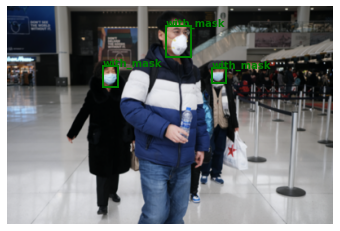

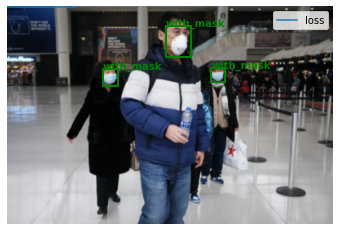

tensor(18.5711, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [53]:
num_epochs = 50
model.to(device)
history = []    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_dataloader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in train_dataloader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
        if i % 21 == 0:
            clear_output(True) 
            history.append(losses.cpu().data.numpy())
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()
        if i % 41 == 0:
            plt.clf()
            model.eval()
            img, annat = next(iter(val_dataloader))
            img = [i.to(device) for i in img]
            pred = model(img)
            show_image(img[0], annat[0], 'train')
            show_image(img[0], pred[0])
            model.train()   
    print(epoch_loss)

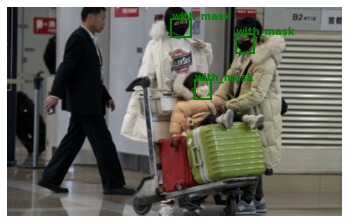

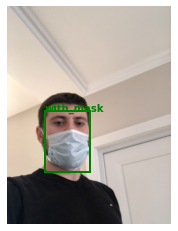

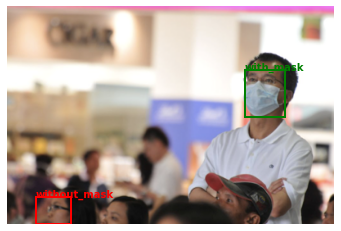

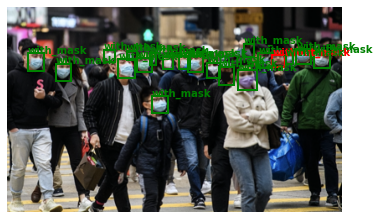

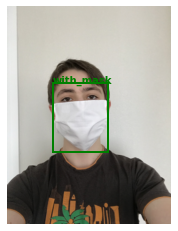

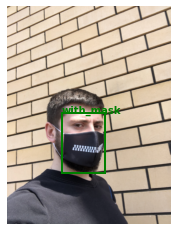

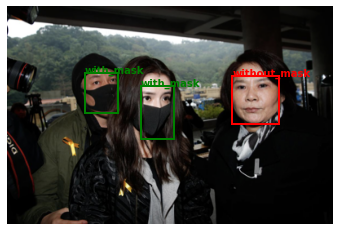

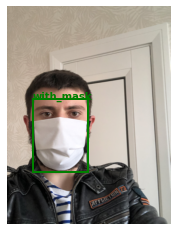

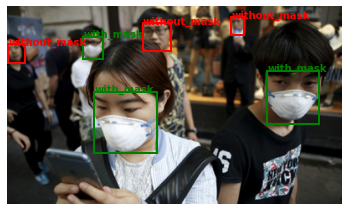

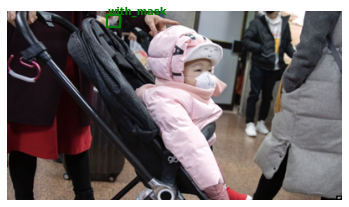

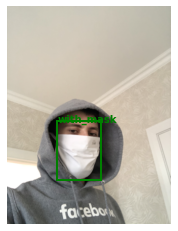

In [54]:
model.eval()
for idx, (img, _) in enumerate(val_dataset):
    prediction = model([img.to(device)])
    show_image(img, prediction[0])
    if idx == 10:
        break
    